In [1]:
%matplotlib inline

In [28]:
import pandas as pd
import numpy as np
import stingray
import numpy as np
from stingray import Lightcurve, Crossspectrum, AveragedCrossspectrum
import datetime
from astropy.time import Time
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
#%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

In [3]:
# import some modules
import numpy as np
import matplotlib.pyplot as plt
import stingray

# choose style of plots, `seaborn-talk` produce nice big figures
plt.style.use('seaborn-talk')



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Setup a plot such that only the bottom spine is shown
def setup(ax):
    #ax.spines['right'].set_color('none')
    #ax.spines['left'].set_color('none')
    #ax.yaxis.set_major_locator(ticker.NullLocator())
    #ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
    
    #ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', width=1.00)
    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', width=0.75)
    ax.tick_params(which='minor', length=2.5)
    #ax.patch.set_alpha(0.9)

In [5]:
marker1=['*','+','x','v','^','<','>','1','2','3','4','8','p','P','h','H','X','D','d','|','_']
color1=['red','green','blue','cyan','lightblue','tan','gold','sandybrown','olivedrab','chartreuse','darkgreen','m','skyblue','violet','crimson','aqua','purple','magenta','yellow','lime','turquoise','lightcyan','teal','indigo']

In [6]:
def get_namelist(df,name):
    state=df[name]
    stateori=[]
    for i in state:
        if i not in stateori:
            stateori.append(i)
    return stateori

# load radio data

In [7]:
radiomrk1018=pd.read_excel('/Users/brettlv/Downloads/vla_archival_survey.xlsx',sheet_name='Sheet2')
radiomrk1018=radiomrk1018[radiomrk1018['frequency'].notnull()]
filename=radiomrk1018


parax='meanepoch'
paraxerr='terr'
parax1='Datestart'
parax2='Datestop'
paray='Fint(mJy)'
parayerr='rms'
paralist='band'

t1=np.array(pd.to_datetime(filename[parax1]),dtype='datetime64[D]')
t2=np.array(pd.to_datetime(filename[parax2]),dtype='datetime64[D]')

tmean=t1+(t2-t1)/2
terr=(t2-t1)/2

filename['meanepoch']=tmean
filename['terr']=terr
namelist=['L', 'C', 'X', 'K',]
#print(namelist)

namelistall=get_namelist(filename,paralist)
print(len(namelistall))
print(namelistall)

5
['L', 'C', nan, 'X', 'K']


filename

## radio lightcurve

['L', 'C', 'X']


/Users/brettlv/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


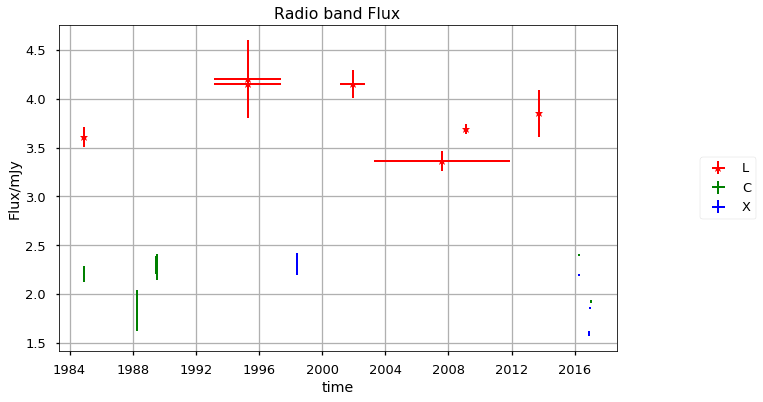

In [8]:
plt.figure(figsize=(10,6))
namelist=['L', 'C','X']
print(namelist)
for i,m,c, in zip(namelist,marker1[:len(namelist)],color1[:len(namelist)]):
    x=filename[filename[paralist]==i][parax]
    xerr=filename[filename[paralist]==i][paraxerr]
    y=filename[filename[paralist]==i][paray]
    yerr=filename[filename[paralist]==i][parayerr]
    plt.errorbar(x,y,xerr=xerr,yerr=yerr,marker=m,color=c,label=i,fmt='o',elinewidth=2)
    #print(x,i)
    
plt.xlabel('time')
plt.ylabel('Flux/mJy')
plt.title('Radio band Flux')
#plt.legend()
#plt.xlim(1980,2019)
plt.legend(loc='center', bbox_to_anchor=(1.2, 0.5),ncol=1)
plt.grid()
plt.show()

# rescale radio flux

In [9]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.optimize import least_squares, curve_fit
from scipy.stats import f
import emcee
import corner
import os
from timeit import default_timer as timer

def calc_power_law(freq,S0,alpha):
    S = S0 * (freq) ** alpha
    return S

def alpha_calc(data):    
    #Get lightcurve values
    freqs = data['frequency']
    flux = data['Fint(mJy)']
    flux_errs = data['rms']
    
    #Use the scipy curve_fit algorithm to calculate the best fit value
    popt, pcov = curve_fit(calc_power_law, freqs, flux ,sigma=flux_errs, p0=(50,-0.61),absolute_sigma=True)
    
    alpha = popt[1] #Best-fit spectral index
    alpha_err = np.sqrt(np.diag(pcov))[1] #Uncertainty in alpha
    
    return alpha, alpha_err
def scale_data(data, alpha, alpha_err, ref_freq=5.0):
    #calculate a scaling factor for the flux density and uncertainty
    f_scale = (ref_freq/data['frequency'])**alpha
    rms_scale = np.abs(f_scale*np.log(ref_freq/data['frequency'])*alpha_err)
    
    #scale the flux and uncertainty - don't forget to add errors in quadrature
    scaled_flux = data['Fint(mJy)'] * f_scale
    scaled_rms = np.abs(scaled_flux) * np.sqrt((data['rms']/data['Fint(mJy)'])**2 + (rms_scale/f_scale)**2)
    
    #Add two new columns to the data
    data['scaled_flux'] = scaled_flux
    data['scaled_rms'] = scaled_rms    
    return data

In [14]:
sel_data2 = radiomrk1018[radiomrk1018['Datestart'] == '1984-11-28']
alpha, alpha_err = alpha_calc(sel_data2)
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))


alpha = -0.42 +/- 0.04


In [16]:
sel_data2 = radiomrk1018[radiomrk1018['Datestart'] == '2016-04-03'][:2]
alpha, alpha_err = alpha_calc(sel_data2)
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

alpha = -0.17 +/- 0.01


In [ ]:
radiomrk1018

In [21]:
bandlist=['L', 'C','X']
bandL=radiomrk1018[radiomrk1018['band']==bandlist[0]]
bandC=radiomrk1018[radiomrk1018['band']==bandlist[1]] 
bandX=radiomrk1018[radiomrk1018['band']==bandlist[2]]
sel_data3=pd.concat([bandL,bandC,bandX],ignore_index=True)   

In [29]:
sel_data3['mjd_start']=convert_mjd(pd.to_datetime(sel_data3['Datestart']))
sel_data3['mjd_stop']=convert_mjd(pd.to_datetime(sel_data3['Datestop']))
sel_data3['meanmjd']=(sel_data3['mjd_stop']+sel_data3['mjd_start'])/2
sel_data3['mjderr']=(sel_data3['mjd_stop']-sel_data3['mjd_start'])/2

In [33]:
scaleddata=scale_data(sel_data3, alpha=-0.42, alpha_err=0.04, ref_freq=8.4)

In [31]:
scaleddata.columns

Index(['Datestart', 'Datestop', 'project', 'mean epoch year', 'mean(mjd)',
       'terr(mjd)', 'band', 'frequency', 'Unnamed: 8', 'peak(mJy/beam)',
       'Fint(mJy)', 'err', 'rms', 'unit', 'proposal', 'paper', 'Unnamed: 16',
       'meanepoch', 'terr', 'mjd_start', 'mjd_stop', 'meanmjd', 'mjderr',
       'scaled_flux', 'scaled_rms'],
      dtype='object')

In [36]:
scaleddata.loc[:,['meanmjd', 'mjderr',
       'scaled_flux', 'scaled_rms','band', 'frequency','Fint(mJy)', 'rms','project','proposal', 'paper']].to_csv('/Users/brettlv/blog/IHEP_sync/paper/dataMrk1018/Mrk1018radiolc_rescaleto8.4GHz_alpha_0.42.csv')

In [35]:
scaleddata1=scale_data(sel_data3, alpha=-0.17, alpha_err=0.01, ref_freq=8.4)

In [37]:
scaleddata1.loc[:,['meanmjd', 'mjderr',
       'scaled_flux', 'scaled_rms','band', 'frequency','Fint(mJy)', 'rms','project','proposal', 'paper']].to_csv('/Users/brettlv/blog/IHEP_sync/paper/dataMrk1018/Mrk1018radiolc_rescaleto8.4GHz_alpha_0.17.csv')

In [ ]:
pwd

scaleddata.to_csv('/Users/brettlv/blog/IHEP_sync/paper/dataMrk1018/Mrk1018radiolc_rescale.csv')

In [ ]:
scaleddata

In [ ]:
scaleddata['meanepoch'],scaleddata['Fint(mJy)'],scaleddata['scaled_flux']

# load xrt optical data

## xrt

In [ ]:
xrtdatalv=pd.read_csv('/Users/brettlv/blog/IHEP_sync/paper/dataMrk1018/Mrkxrtmore85.csv')
xrtfitlv=pd.read_csv('/Users/brettlv/blog/IHEP_sync/paper/dataMrk1018/xspecfitdatamorethan85.txt',header=None)
xrtfitlv.columns=['powerlawindex','indexerr','bins','rechied','flux','fluxrangeleft','fluxrangeright','obs_id']

In [ ]:
xrtdatalv_less85=pd.read_csv('/Users/brettlv/blog/IHEP_sync/paper/dataMrk1018/Mrkxrtless85.csv')
xrtfitlv_less85=pd.read_csv('/Users/brettlv/blog/IHEP_sync/paper/dataMrk1018/xspecfitdatalessthan85.txt',header=None)
xrtfitlv_less85.columns=['powerlawindex','indexerr','bins','rechied','flux','fluxrangeleft','fluxrangeright','obs_id']

## husemann2016 and optical

In [ ]:
optical=pd.read_excel('/Users/brettlv/blog/IHEP_sync/paper/dataMrk1018/MRK1018optical.xlsx')
husemann2016=pd.read_csv('/Users/brettlv/blog/IHEP_sync/paper/dataMrk1018/husemann2016.csv')

In [ ]:
xrtdatalv_less85.columns,

In [ ]:
optical.columns

# all lightcurve

In [ ]:
xrtfitlv

In [ ]:
xrtfitlv_less85

## load data

In [ ]:
x1 = optical['timeoptical']
y1 = optical['magAB']
x2=xrtdatalv['xrttime']#counts more than 85
y2 = xrtfitlv['flux']
p2=xrtfitlv['powerlawindex']
errp2=xrtfitlv['indexerr']


x3=xrtdatalv_less85['xrttime']
y3=xrtfitlv_less85['flux']
p3=xrtfitlv_less85['powerlawindex']
errp3=xrtfitlv_less85['indexerr']

x4=husemann2016['date']
y4=husemann2016['flux']
erry4=husemann2016['ferr']
p4=husemann2016['gamma']
errp4=husemann2016['gerr']

x5=scaleddata['meanepoch']#rescale to 5GHz
y5=scaleddata['scaled_flux']
erry5=scaleddata['scaled_rms']

In [ ]:
husemann2016

In [ ]:
plt.plot(xrtfitlv_less85['bins'],xrtfitlv_less85['rechied'],'r.')
plt.show()

In [ ]:
plt.plot(x4mjd,p4,'r.',label='husemann')
plt.plot(x2mjd,p2,'g.',label='xrt>85')
#plt.plot(x3mjd,p3,'b.',label='xrt<85')
plt.legend()
plt.show()

## time convert

In [26]:
from datetime import timedelta, datetime
import time
def convert_partial_year(numbers):
    datetimes=[]
    for number in numbers:
        year = int(number)
        d = timedelta(days=(number - year)*(365 + is_leap(year)))
        day_one = datetime(year,1,1)
        date = d + day_one
        datetimes.append(date)
    return datetimes

def is_leap(year):
    if not year%4 and  year%100 or not year%400:
        return True
    return False

def convert_mjd(times):
    timesmjd=[]
    for i in times:
        timesmjd.append(Time(i).mjd)
    return timesmjd   

    

In [ ]:
x1new=convert_partial_year(x1)
x1mjd=Time(x1new).mjd
x2mjd=convert_mjd(pd.to_datetime(x2))
x3mjd=convert_mjd(pd.to_datetime(x3))
x4mjd=husemann2016['date']
x5mjd=convert_mjd(pd.to_datetime(x5))

In [ ]:
optical['mjd']=x1mjd

In [ ]:
optical.to_csv('/Users/brettlv/blog/IHEP_sync/paper/dataMrk1018/Mrk1018opticallc.csv')

# Optical vs X-ray

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.scatter(x1mjd, y1,marker='^',color='b',label='optical')
ax1.invert_yaxis()
ax1.set_ylabel('magAB')
ax1.legend(bbox_to_anchor=(1.3, 0.5))
#ax1.set_xlim([2002, 2018])
#ax1.set_title("Double Y axis")


ax2 = ax1.twinx()  # this is the important function
#ax2 = fig.add_subplot(212)
ax2.scatter(x2mjd, y2*10**11, marker='*',color='r',label='xrt')
ax2.scatter(husemann2016['date'],husemann2016['flux'],marker='.',color='g',label='Husemann')
#ax2.set_xlim([2002, 2018])
ax2.set_ylabel('xray flux')
ax2.set_xlabel('time')
plt.legend(bbox_to_anchor=(1.3, 0.9))
plt.show()

# AB magnitude System
This magnitude system is defined such that, when monochromatic flux f is measured in erg sec^-1 cm^-2 Hz^-1,
m(AB) = -2.5 log(f) - 48.60
where the value of the constant is selected to define m(AB)=V for a flat-spectrum source. In this system, an object with constant flux per unit frequency interval has zero color.
References:

Oke, J.B. 1974, ApJS, 27, 21

In [ ]:
opticalflux=(-48.60-optical['magAB'])/2.5

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.scatter(x1mjd, opticalflux,marker='^',color='b',label='optical')
#ax1.invert_yaxis()
ax1.set_ylabel('opticalflux')
ax1.legend(bbox_to_anchor=(0.2, 0.5),ncol=1, mode="expand", borderaxespad=0.)
#ax1.set_xlim([2002, 2018])
#ax1.set_title("Double Y axis")


ax2 = ax1.twinx()  # this is the important function
#ax2 = fig.add_subplot(212)
ax2.scatter(x2mjd, np.log10(y2), marker='*',color='r',label='xrt')
ax2.scatter(husemann2016['date'],np.log10(husemann2016['flux']*1.0e-11),marker='.',color='g',label='Husemann')
#ax2.set_xlim([2002, 2018])
ax2.set_ylabel('xray flux')
ax2.set_xlabel('time')
#plt.legend(bbox_to_anchor=(0.8, 0.9),ncol=1,loc='upper right', mode="expand", borderaxespad=0., shadow=True)
ax2.legend(bbox_to_anchor=(1.2, 0.9),ncol=1, mode="expand", borderaxespad=0.)
plt.legend()
plt.show()

In [ ]:
def

# Radio vs X-ray

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.errorbar(x5mjd, y5,yerr=erry5,marker='.',color='gold',label='radio',fmt='.')
#ax1.invert_yaxis()
ax1.set_ylabel('radioflux')
ax1.legend(bbox_to_anchor=(0, 0.9),ncol=1)
#plt.legend()
#ax1.set_xlim([2002, 2018])
#ax1.set_title("Double Y axis")


ax2 = ax1.twinx()  # this is the important function
#ax2 = fig.add_subplot(212)
ax2.scatter(x2mjd, np.log10(y2), marker='*',color='r',label='xrt')
ax2.scatter(husemann2016['date'],np.log10(husemann2016['flux']*1.0e-11),marker='+',color='g',label='Husemann')
#ax2.set_xlim([2002, 2018])
ax2.set_ylabel('xray flux')
ax2.set_xlabel('time')
#plt.legend(bbox_to_anchor=(0.8, 0.9),ncol=1,loc='upper right', mode="expand", borderaxespad=0., shadow=True)
ax2.legend(bbox_to_anchor=(1.3, 0.9),ncol=1)
#plt.legend()
plt.show()

In [ ]:
husemann2016

In [ ]:
l1 = [x1mjd,opticalflux]
l2= [x2mjd,np.log10(y2)]
head = ["mjdtime" , "flux" ]

df1 = pd.DataFrame(l1 , index = head).T
#df1['err']=0.1
df1=df1.sort_values(by=['mjdtime'])
df1.to_csv("/Users/brettlv/timing_analysis/pydcf/example/Mrkopticalmjd.csv", header=None,index=None, encoding = "utf-8")

df2 = pd.DataFrame(l2 , index = head).T
df2=df2.sort_values(by=['mjdtime'])
#df2['err']=0.1
df2.to_csv("/Users/brettlv/timing_analysis/pydcf/example/Mrkxrtmjd.csv" , header=None,index=None,encoding = "utf-8")

The reported correlation relates to the first time series. That is, how the first time series should be shifted to match the second, ie: ts2 = ts1 - correlation. Positive correlation is ts1 leading ts2, negative correlation is ts1 lagging ts2.

In [ ]:
python3 dcf.py example/Mrkopticalmjd.csv example/Mrkxrtmjd.csv -2000 2000 20 -v -w=gauss -p=2 -o

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.scatter(x1mjd, opticalflux,marker='^',color='b',label='optical')
#ax1.invert_yaxis()
ax1.set_ylabel('opticalflux')
ax1.legend(bbox_to_anchor=(0.2, 0.5))
#ax1.set_xlim([2002, 2018])
#ax1.set_title("Double Y axis")


ax2 = ax1.twinx()  # this is the important function
#ax2 = fig.add_subplot(212)
ax2.scatter(x2mjd, np.log10(y2), marker='*',color='r',label='xrt')
ax2.scatter(husemann2016['date'],np.log10(husemann2016['flux']*1.0e-11),marker='.',color='g',label='Husemann')
#ax2.set_xlim([2002, 2018])
ax2.set_ylabel('xray flux')
ax2.set_xlabel('time')
plt.legend(bbox_to_anchor=(0.8, 0.9))
plt.show()

In [ ]:
(2.470e-12 - 2.505e-12)/2

In [ ]:
husemann2016

## online pptx

In [ ]:
%%HTML
<div align="center"><iframe src="https://view.officeapps.live.com/op/view.aspx?src=https://developer.download.nvidia.com/training/courses/C-AC-01-V1/AC_CUDA_C-zh/AC_CUDA_C_1-zh.pptx" frameborder="0" width="900" height="550" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe></div>

## online pptx

In [ ]:
%%HTML
<div align="center"><iframe src="https://view.officeapps.live.com/op/view.aspx?src=https://brettlv.github.io/radiolearnnote/v404_notebook_lvbing_20180104.pptx" frameborder="0" width="900" height="550" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe></div>

## plot pd

In [ ]:
husemann2016

In [ ]:
markers_pd=['*','.','+','<','v','^','x','>','1','2','3','4','8','p','P','h','H','X','D','d','|','_']
colors_pd=['red','green','blue','cyan','lightblue','tan','gold','sandybrown','olivedrab','chartreuse','darkgreen','m','skyblue','violet','crimson','aqua','purple','magenta','yellow','lime','turquoise','lightcyan','teal','indigo']
print(len(markers_pd))
print(len(colors_pd))

In [ ]:
husemann2016.columns

In [ ]:
ins=husemann2016['ins']
ins=ins.drop_duplicates()

In [ ]:
len(ins)

## scatter plot

In [ ]:
from collections import OrderedDict
import matplotlib.pyplot as plt
 

def plot_data(data,x,y,color_n=None,marker_n=None,**kwargs):
    fig = plt.figure(figsize=(4,3),dpi=400)
    ax = fig.add_subplot(111)    
    pcolor=data[color_n].drop_duplicates()
    pmarker=data[marker_n].drop_duplicates()        
    marker_dict = dict(zip(pmarker, markers_pd[:len(pmarker)]))
    color_dict= dict(zip(pcolor, colors_pd[:len(pcolor)]))
    
    for row in range(len(data)):
        
        px=data.loc[row][x]
        py=data.loc[row][y]             
        marker =marker_dict[data.loc[row][marker_n]]
        color= color_dict[data.loc[row][color_n]]
        label= marker_n+':'+str(data.loc[row][marker_n])+','+color_n+':'+str(data.loc[row][color_n])
        #print(px,py,marker,color)
        ax.scatter(px, py, marker=marker, color=color,label=label, **kwargs)
    #return
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 1.0),ncol=1,fontsize=5)
    plt.show()
    #return marker_dict,color_dict   
plot_data(husemann2016,x='date',y='flux',color_n='chi',marker_n='ins')    

## plot cmap

In [ ]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
import matplotlib.colors as colors



#cm=matplotlib.cm.coolwarm()
#cm=plt.cm.get_cmap('RdYlBu')
def cmap_setup(cmap='viridis', min_freq=0, max_freq=20):
    '''
    This function will set up a scalar map for you to colour your markers by frequency
    '''
    freq_cmap = plt.cm.get_cmap(cmap)
    
    cNorm  = colors.Normalize(vmin=min_freq, vmax=max_freq)
    scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
    sm = scalarMap
    sm._A = []    
    return sm  


def plot_data_cmap(data,x,y,color_n=None,marker_n=None,size=None):  
    fig = plt.figure(figsize=(4,3),dpi=400)
    ax = fig.add_subplot(111)  
    #Get the scalar map, plot the data using the plot_data function above    
    pmarker=data[marker_n].drop_duplicates()        
    marker_dict = dict(zip(pmarker, markers_pd[:len(pmarker)]))
    sm = cmap_setup(cmap='coolwarm', min_freq=min(data[color_n]), max_freq=max(data[color_n])) 
    for i,(i_,j_,c_,m_) in enumerate(zip(data[x],data[y],data[color_n],data[marker_n])):      
        marker =marker_dict[m_]
        colorval = sm.to_rgba(c_)        
        size=10+(c_-min(data[color_n]))/(max(data[color_n])-min(data[color_n]))*20     
        ax.scatter(i_,j_,linestyle='--', marker=marker, color=colorval,label=m_,s=size,alpha=0.5) 
    cbar = fig.colorbar(sm,fraction=0.046, pad=0.04)
    cbar.set_label(color_n)            
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(0.3, 0.9),ncol=1,fontsize=5)
    plt.show()    
    
    #return marker_dict,color_dict
plot_data_cmap(husemann2016,x='flux',y='gamma',color_n='date',marker_n='ins')    
    

## cmap errorbar

In [ ]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
import matplotlib.colors as colors



#cm=matplotlib.cm.coolwarm()
#cm=plt.cm.get_cmap('RdYlBu')
def cmap_setup(cmap='viridis', min_freq=0, max_freq=20):
    '''
    This function will set up a scalar map for you to colour your markers by frequency
    '''
    freq_cmap = plt.cm.get_cmap(cmap)
    
    cNorm  = colors.Normalize(vmin=min_freq, vmax=max_freq)
    scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
    sm = scalarMap
    sm._A = []    
    return sm  

def plot_data_cmap(data,x,y,xerr=None,yerr=None,color_n=None,marker_n=None,size=None):  
    fig = plt.figure(figsize=(4,3),dpi=400)
    ax = fig.add_subplot(111)  
    #Get the scalar map, plot the data using the plot_data function above    
    pmarker=data[marker_n].drop_duplicates()        
    marker_dict = dict(zip(pmarker, markers_pd[:len(pmarker)]))
    sm = cmap_setup(cmap='coolwarm', min_freq=min(data[color_n]), max_freq=max(data[color_n])) 
    mincolor=min(data[color_n])
    maxcolor=max(data[color_n])    
    for i in range(len(data)):
        i_=data.loc[i][x]
        j_=data.loc[i][y]
        x_=data.loc[i][xerr]
        y_=data.loc[i][yerr]            
        marker =marker_dict[data.loc[i][marker_n]]#maker
        label= data.loc[i][marker_n]#label         
        colorval = sm.to_rgba(data.loc[i][color_n])            
        size=10+(c_-mincolor)/(mincolor-maxcolor)*20     
        ax.errorbar(i_,j_,xerr=x_,yerr=y_,linestyle='--', marker=marker, color=colorval,label=label,alpha=0.5) 
    
    cbar = fig.colorbar(sm,fraction=0.046, pad=0.04)
    cbar.set_label(color_n)            
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(0.3, 0.9),ncol=1,fontsize=5)
    plt.show()    
    
    #return marker_dict,color_dict
plot_data_cmap(husemann2016,x='flux',y='gamma',xerr='ferr',yerr='gerr',color_n='date',marker_n='ins')    
    

In [ ]:
import os,sys


def get_file_list(pwdpath):
    dirname=os.listdir(pwdpath)
    dirname_select=[]
    dirs=[]
    for i in dirname:
        if i.endswith('.png') or i.endswith('.html'):
            dirname_select.append(i)
        if os.path.isdir(os.path.join(pwdpath,i)):
            dirs.append(i)
            
    return dirname_select,dirs

pwdpath='/Users/brettlv/blog/brettlv.github.io/pythoncode/Mrk1018'

In [ ]:
dirname_select,dirs=get_file_list(pwdpath)

In [ ]:
dirname_select,dirs